In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import jcl
from scipy.signal import savgol_filter
from functools import cached_property
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cosine
import pickle
import os

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
def speed_filter(positions, bin_len, speed_thr, speed_violation = 90):
    """ Filter positions based on speed.
        Return both parts where speed > speed_thr and where speed <= speed_thr.

            positions - array of positions of shape (n,1) or (n,2)
            bin_len - duration of temporal bins in ms
            speed_thr - threshold for speed
            speed_violation - speed in cm/s that is max achievable by rat
        Return:
            positions speed filtered with low speed set to 0, low speed position indices
    """
    assert speed_thr is not None
    window_size = 50
    poly_degree = 1
    # Apply the Savitzky-Golay filter
    smooth_pos = position.copy()
    smooth_pos[:,0] = savgol_filter(position[:,0], window_size, poly_degree)
    smooth_pos[:,1] = savgol_filter(position[:,1], window_size, poly_degree)
    
    speed = np.array( jcl.utils.calc_speed(smooth_pos,bin_len) )
    
    speed_violation_index = np.where(speed > speed_violation)[0]
    for i in speed_violation_index:
        speed[i]= np.mean(speed[i-10:i])
        
    # Window size and polynomial degree for the Savitzky-Golay filter
    window_size = 50
    poly_degree = 1
    # Apply the Savitzky-Golay filter
    smooth_speed = savgol_filter(speed, window_size, poly_degree)
    speed_l_idx = smooth_speed < speed_thr
    
    speed_filtered_positions = smooth_pos.copy()
    speed_filtered_positions[speed_l_idx] = [0,0]
    return speed_filtered_positions, speed_l_idx, smooth_speed,speed, smooth_pos

class Map:
    
    def __init__(self, mmap):
        self.__map = mmap
        self.__map_prob = None

    @property
    def map(self):
        """ Return the underlying map. """
        return self.__map

    @property
    def map_prob(self):
        """ Return the underlying map normalized to sum of 1. """
        if self.__map_prob is None:
            self.__map_prob = self.__map / self.__map.sum()
        return self.__map_prob

    # a map is an array
    # so we implement methods that are
    # absolutely essential for an array
    def __getitem__(self, idx):
        return self.__map.__getitem__(idx)

    @property
    def ndim(self):
        return self.__map.ndim

    @property
    def shape(self):
        return self.__map.shape

    @property
    def size(self):
        return self.__map.size


class OccupancyMap(Map):
    def __init__(self, positions, maze_size, bin_size, bin_len, smooth_sd=None):
        """ Produce occupancy map.

            Args:
                positions - array of positions of shape (n,1) or (n,2)
                maze_size - size of the maze in the same units as positions
                bin_size - size of spatial bins in the same units as positions
                bin_len - duration of temporal bins in ms
                smooth_sd - SD in bins for gaussian smoothing
            Return:
                occupancy - time in seconds spent in each spatial bin
        """
        self.binner = Binning(bin_size, maze_size)
        super().__init__(self.__compute_occ(positions, self.binner, bin_len, smooth_sd))
        self.bin_size = bin_size

    @staticmethod
    def __compute_occ(positions, binner, bin_len, smooth_sd=None):
        occupancy = np.zeros(binner.num_bins, dtype= np.int64)

        for p in positions:
            
            bin_idx = binner.bin_idx(p)
            num_bins = binner.num_bins - 1
#             print(num_bins)
            if ( abs( bin_idx[0] - bin_idx[1] )   !=   num_bins[0] ) and ( abs( bin_idx[0] - bin_idx[1] )   !=  0 ):
                occupancy[bin_idx] += bin_len
#         np.savetxt("./occup.csv",occupancy, fmt='%d',delimiter=",")
        if smooth_sd is not None:
            occupancy = gaussian_filter(occupancy, smooth_sd)
#         np.savetxt("./occup_smooth.csv",occupancy, fmt='%d',delimiter=",")

        return occupancy / 1000  # ms to seconds


class FiringRateMap(Map):
    def __init__(self, spike_train, positions, maze_size, bin_size, bin_len, smooth_sd=3):
        """ Produce firing rate map for the given single cell spike train.

            Args:
                positions - array of positions of shape (n,1) or (n,2)
                maze_size - size of the maze in the same units as positions
                bin_size - size of spatial bins in the same units as positions
                bin_len - duration of temporal bins in ms
                smooth_sd - SD in bins for gaussian smoothing
            """
        __fr_map, __occupancy = self.__compute_frm(spike_train, positions, maze_size, bin_size, bin_len, smooth_sd)
        super().__init__(__fr_map)
        self.__occupancy = __occupancy
        self.bin_size = bin_size
        self.__eps = 1e-15
        self.__I_sec = None
        self.__I_spike = None
        self.__sparsity = None
        self.__frs = None # mean, median, max

    @property
    def occupancy(self):
        """ Occupancy map. """
        return self.__occupancy
    
    @property
    def peak_fr(self):
        """ Peak firing rate in Hz. """
        if self.__frs is None:
            self.__frs = self.__compute_frs()
        return self.__frs[2]

    @property
    def mean_fr(self):
        """ Mean firing rate in Hz. """
        if self.__frs is None:
            self.__frs = self.__compute_frs()
        return self.__frs[0]
    
    def __compute_frs(self):
        """ Compute mean, median and max firing rates from given firing rate map.
            Ignore nans, infs and values smaller than eps.

            Return:
                (mean, median, max) FR in Hz
        """
        not_nan = np.logical_not(np.isnan(self.map))
        not_inf = np.logical_not(np.isinf(self.map))
        good = np.logical_and(not_nan, not_inf)
        good = np.logical_and(good, self.map >= self.__eps)
        frm = self.map[good]
        if frm.size == 0:
            return 0, 0, 0
        return frm.mean(), np.median(frm), frm.max()

    @staticmethod
    def __compute_frm(spike_train, positions, maze_size, bin_size, bin_len, smooth_sd):
        """ Produce firing rate map for the given single cell spike train.

            Args:
                positions - array of positions of shape (n,1) or (n,2)
                maze_size - size of the maze in the same units as positions
                bin_size - size of spatial bins in the same units as positions
                bin_len - duration of temporal bins in ms
                smooth_sd - SD in bins for gaussian smoothing
                return_occupancy - whether to return occupancy map
            Return:
                firing rate map - matrix with firing rate (Hz) in each spatial bin
        """
        
        assert len(spike_train) == len(positions)
        occupancy = OccupancyMap(positions, maze_size, bin_size, bin_len, smooth_sd)
        frm = np.zeros_like(occupancy.map)

        for p, sn in zip(positions, spike_train):
            bin_idx = occupancy.binner.bin_idx(p)
            frm[bin_idx] += sn

        frm = frm / occupancy.map
        frm[np.isnan(frm)] = 0
        frm[np.isinf(frm)] = 0
        frm = gaussian_filter(frm, smooth_sd)
        return frm, occupancy

class Binning:
    def __init__(self, bin_size, maze_size):
        self.bin_size = bin_size
        self.maze_size = maze_size
        
    def bin_idx(self, p):
        """ Calculate bin index for given position.

            Args:
                p - position
                bin_size - size of bins, single number or same shape as `p`
                maze_size - size of the maze (number of bins per dimension)
            Return:
                bin index - tuple of the same shape as `p`
        """
        idx = tuple((p // self.bin_size).astype(int))
        # origin to lower left corner
        return (self.num_bins[1] - idx[1] - 1, idx[0])

    @cached_property
    def num_bins(self):
        """ Calculate number of spatial bins (per dimension). """
        return 1 + (np.array(self.maze_size) / self.bin_size).astype(int)
    
def plot_map(m: Map, title=None, colorbar_label=None, path=None):
    """ Plot given with added color bar."

        Args:
            m - map
            title - figure title
            colorbar_label - label to be used for the colorbar
            path - file path to which to save the figure, if none show the figure
    """
    if m.ndim == 1:
        im = np.expand_dims(m.map, 1)
        im = np.repeat(im.map, 3, 1).T
    else:
        im = m.map
        
    # Create a figure and axis
    fig, ax = plt.subplots()

    plt.set_cmap("jet")
    plt.imshow(im)

#     # Add the label text in black
#     ax.text(33, 13, "Start", fontsize=12, color='white', ha='center', va='center')
#     ax.text(14, 5, "Chocolate", fontsize=12, color='white', ha='center', va='center')
#     ax.text(38, 25, "Honey", fontsize=12, color='white', ha='center', va='center')

    cb = plt.colorbar(ticks=[0., np.max(im)])
    if colorbar_label is not None:
        cb.set_ticklabels([0, np.round(np.max(im))])
        cb.set_label("Hz", fontsize=18)

    if title is not None:
        plt.title(title)

    if path is not None:
        plt.savefig(path)
    else:
        plt.show()
    plt.close()    
    
class ClusterPopulation():
    """
    A population of neurons from a given recording day. Each neuron is a ClusterUnit object.

    Assumptions: It assumes that cluster 0 contains artifacts and cluster 1 contains the noise in the clu file.
                 Trial files are assumed to start at 01 with sleep and first trial is file 02. This is important in functions that use session_shifts.
                 All spatial calculations assume a linear maze. Maze length and spatial bin size can be changed when generating ratemaps.
                 For 2D ratemaps, check func_basics.
                 Recording rates in Hz (for res, whl and session_shifts) are optional variables that might need to be changed.
                 These assumptions are also valid for the ClusterUnit class.

    Saving/Loading: to export the object use pickle.dump and to load, pickle.load
    """

    def __init__(self,binned_data):

        self.nclusters = binned_data.shape[0]
        self.unit = np.array( [None]*self.nclusters )
        self.mean_fr = np.zeros( [binned_data.shape[0], 1] )


/tmp/ipykernel_4143/2607735171.py:189: RuntimeWarning: divide by zero encountered in divide
  frm = frm / occupancy.map
/tmp/ipykernel_4143/2607735171.py:189: RuntimeWarning: invalid value encountered in divide
  frm = frm / occupancy.map


0 done out of 98
1 done out of 98
2 done out of 98
3 done out of 98
4 done out of 98
5 done out of 98
6 done out of 98
7 done out of 98
8 done out of 98
9 done out of 98
10 done out of 98
11 done out of 98
12 done out of 98
13 done out of 98
14 done out of 98
15 done out of 98
16 done out of 98
17 done out of 98
18 done out of 98
19 done out of 98
20 done out of 98
21 done out of 98
22 done out of 98
23 done out of 98
24 done out of 98
25 done out of 98
26 done out of 98
27 done out of 98
28 done out of 98
29 done out of 98
30 done out of 98
31 done out of 98
32 done out of 98
33 done out of 98
34 done out of 98
35 done out of 98
36 done out of 98
37 done out of 98
38 done out of 98
39 done out of 98
40 done out of 98
41 done out of 98
42 done out of 98
43 done out of 98
44 done out of 98
45 done out of 98
46 done out of 98
47 done out of 98
48 done out of 98
49 done out of 98
50 done out of 98
51 done out of 98
52 done out of 98
53 done out of 98
54 done out of 98
55 done out of 98
56

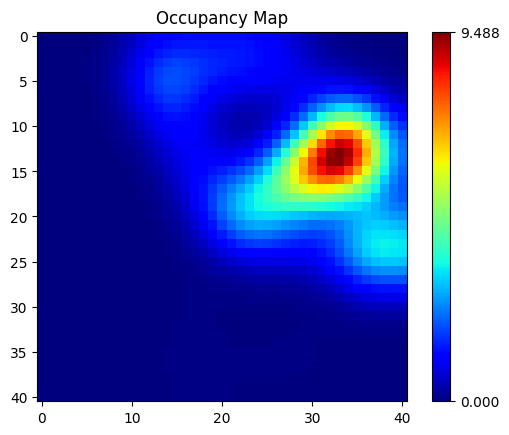

In [7]:
# days = ['09','10','20']
days = ['20']

exp = "JC283-202209"
time_bin = 25.6 # in ms   20ms is 512 pts    20000/39.0625

for day in days:
    
    path = "./m" + exp + day + "/"
    
    results_dir = './m' + exp + day + "/rate_maps_new/"
    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)

    des_path = path + exp + day + '.des'
    
    with open(des_path, 'r') as file:
        des = np.array(file.read().split())
    
    binned_data = np.array([None, None])
    speed_filtered_positions = np.array([None, None])
    smooth_pos = np.array([None, None])
    
    for training_num in [1,2]:

        clu_path = path + exp + day + '_training' + str(training_num) + '.clu'
        res_path = path + exp + day + '_training' + str(training_num) + '.res'
        whl_path = path + exp + day + '_training' + str(training_num) + '.whl'

        spike_times = jcl.load.spike_times_from_res_and_clu( res_path, clu_path, exclude_clusters=[0, 1]  )

        pos = pd.read_csv(   
                            whl_path,
                            sep=" ",
                            header=None,
                            names=["x1","y1"]
        )

        pos["x1"],pos["y1"] = jcl.utils.interpolate_position(pos["x1"], pos["y1"], unknown_val=1023)

        binned_data[training_num-1] = jcl.load.bins_from_spike_times( 
                                    spike_times, 
                                    bin_len = time_bin, #in ms
                                    return_mat_type = np.array
        )


        position = np.column_stack(( pos["x1"], pos["y1"] ))
        speed_filtered_positions[training_num-1], low_speed_index, smooth_speed, raw_speed, smooth_pos[training_num-1] = speed_filter(position, time_bin, 5)
        
        if len(low_speed_index) < binned_data[ training_num-1 ].shape[1]: #since pos and spikes of different lengths, just extending filtering 
            low_speed_index = np.append(low_speed_index, low_speed_index[len(low_speed_index)-binned_data[ training_num-1 ].shape[1]:])
      
        for i in range((binned_data).shape[0]): ## set bins with speed < 5cm/s to 0 spikes  
            binned_data[ training_num-1 ][ : , low_speed_index ] = 0
        

    binned_data = np.concatenate((binned_data[0],binned_data[1]),axis =1)
    speed_filtered_positions = np.concatenate((speed_filtered_positions[0],speed_filtered_positions[1]),axis =0)
    smooth_pos = np.concatenate((smooth_pos[0],smooth_pos[1]),axis = 0)
    
    
    ### position bins and binned data is sometimes of different lengths (1-3 bins max so i just extend the position array. shouldnt make much difference)
    if len(speed_filtered_positions) != len(binned_data[0,:]):
        j = len(speed_filtered_positions) - len(binned_data[0,:])
        if j < 0:
            speed_filtered_positions = np.concatenate( (speed_filtered_positions, speed_filtered_positions[j:,:])   ,axis =0 )

    bin_sizes = [3.2, 4, 5]
    smoothing = [2, 2.5, 3]
    
    place_fields = ClusterPopulation(binned_data)
    
    for i in range(binned_data.shape[0]):

        placemap = FiringRateMap(
                                                binned_data[i, :],
                                                speed_filtered_positions, 
                                                np.array([160,160]), ### MAYBE INCREASE TO 180
                                                np.array([4,4]), 
                                                time_bin
                                                ,smooth_sd= 3
        )

        place_fields.unit[i] = placemap.map
        place_fields.mean_fr[i] = placemap.mean_fr
        plot_map(placemap, title = des[i] +"   Cluster id: "+ str(i+2)+"   Mean Hz: " + str(placemap.mean_fr)[:5]+"   Max Hz: " + str(placemap.peak_fr)[:5],
                path = results_dir + str(i+2) + '_' + des[i]+".svg"
                )
        print(str(i) +" done out of "+ str(binned_data.shape[0]))

    pickle.dump( place_fields, open( day  +"_place_fields" , "wb" ) )
#     break
    plot_map(placemap.occupancy, title = "Occupancy Map")

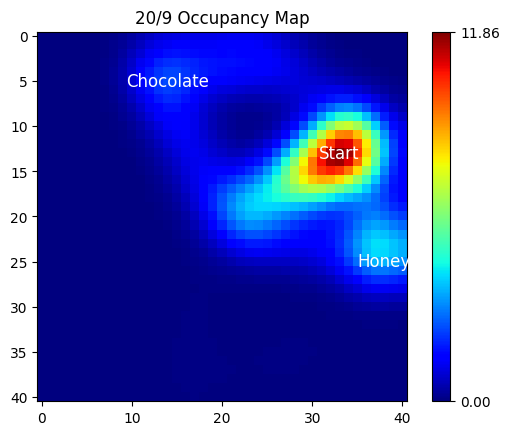

In [23]:
    plot_map(placemap.occupancy, title = "20/9 Occupancy Map")

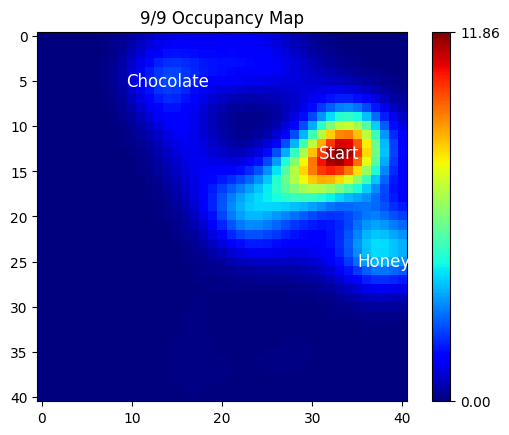

In [24]:
    plot_map(placemap.occupancy, title = "9/9 Occupancy Map")

In [6]:
    pickle.dump( place_fields, open( day  +"_place_fields" , "wb" ) )


In [13]:
days = ['09']
# days = ['10','20']

exp = "JC283-202209"
time_bin = 25.6 # in ms   20ms is 512 pts    20000/39.0625

for day in days:
    
    path = "./m" + exp + day + "/"
    
    for training_num in [1,2]:

        clu_path = path + exp + day + '_training' + str(training_num) + '.clu'
        res_path = path + exp + day + '_training' + str(training_num) + '.res'
        whl_path = path + exp + day + '_training' + str(training_num) + '.whl'
        with open(clu_path, 'r') as file:
            clu = np.array(file.read().split() , dtype = int)
        print(np.unique(clu))



[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215]
[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  

In [17]:
for i in (np.unique(clu)):
    print(clu[clu==i])

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3]
[4 4 4 ... 4 4 4]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5

[82 82 82 ... 82 82 82]
[83 83 83 ... 83 83 83]
[84 84 84 ... 84 84 84]
[85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85
 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85
 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85
 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85
 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85
 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85
 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85
 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85
 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85
 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85
 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85
 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85
 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 

[160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 16

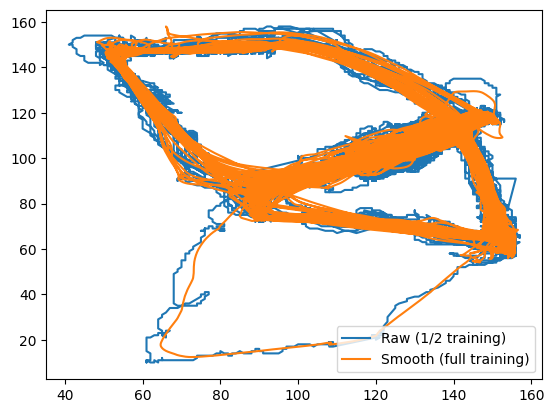

In [172]:
plt.plot(position[:,0],position[:,1],label="Raw (1/2 training)")
plt.plot(smooth_pos[:,0],smooth_pos[:,1],label='Smooth (full training)')
plt.legend()
plt.show()

(0.0, 160.0)

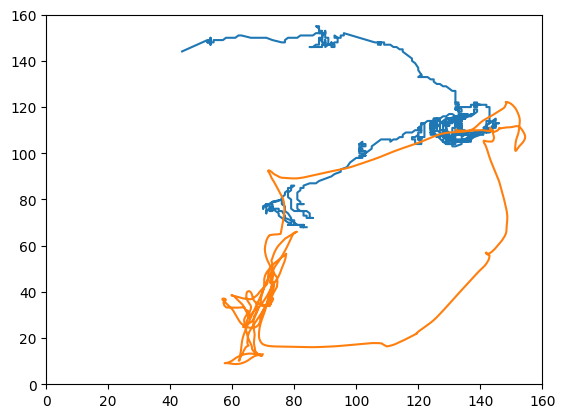

In [120]:
plt.plot(position[10000:16000,0],position[10000:16000,1])
plt.plot(smooth_pos[10000:16000,0],smooth_pos[10000:16000,1])
plt.xlim([0,160])
plt.ylim([0,160])

In [ ]:
def calculate_estimated_position(t0, time_bin_width, place_fields, binned_spikes, position_bins, good_place_cells):
    bayesian_threshold= 10 ** (np.log2(len(place_fields)) - np.log2(8000))

#     print(place_fields.shape)
    place_fields = [np.where(place_cell < bayesian_threshold, bayesian_threshold, place_cell) for place_cell in place_fields]
#     place_fields = [place_cell for place_cell in place_fields]
#     print(len(place_fields))

    position_probability =  np.array( [None]*binned_spikes.shape[1]  )
#     print( position_probability)## make this a stack of matrices
    for j in range( binned_spikes.shape[1] ):
        position_probability[j] = reconstruct( j, time_bin_width, place_fields, binned_spikes[:,j] , position_bins, good_place_cells)
        ## replace the index of the matrix in the stack
        
#     probability = np.max( position_probability, axis = (1,2) )
#     position_index = np.array([ np.unravel_index( np.argmax(matrix, axis=None), matrix.shape ) for matrix in position_probability] )
    position_index = np.array([ np.unravel_index( np.argmax(matrix, axis=None), matrix.shape ) for matrix in position_probability] )
    probs = np.array([np.max(matrix) for matrix in position_probability ])    
    estimated_position = np.array(position_bins[position_index] )
#     index = np.where(probability > 0.2)[0]
#     #print(probability)
#     #print(position_index)
#     #print(index)
#     #estimated_position_time = t0 + bin_width / 2
#     estimated_position_time = t0
    
#     estimated_position_interp = interp1d(estimated_position_time[index]/20000, estimated_position[index], kind='linear',fill_value="extrapolate")(t)
#     return position, estimated_position_time, estimated_position_interp, estimated_position
    return position_probability, estimated_position
#     return position_probability, estimated_position_time, estimated_position

def reconstruct(j, bin_width, place_field, binned_spikes, position_bins, good_place_cells):
    
    product_of_place_fields = np.ones( (position_bins.shape[0], position_bins.shape[0]) ) 
    sum_of_place_fields = np.zeros( (position_bins.shape[0], position_bins.shape[0]) ) 
    bayesian_threshold= 10 ** (np.log2(len(place_field)) - np.log2(8000))

    product_of_place_fields *=  np.prod(np.power(place_field, binned_spikes[:, np.newaxis, np.newaxis]), axis=0)

#     print(np.power(place_field, binned_spikes[:, np.newaxis, np.newaxis])[5])
#     print(np.prod(np.power(place_field, binned_spikes[:, np.newaxis, np.newaxis]), axis=0))
    
    product_of_place_fields[np.isinf(product_of_place_fields)] = 1e300 ## check how big the value is
    product_of_place_fields[np.where(product_of_place_fields==0)[0]] = bayesian_threshold
    
#     print(np.isnan(product_of_place_fields).any())
    sum_of_place_fields += np.sum(place_field, axis = 0)
#     plt.imshow(sum_of_place_fields)
#     plt.colorbar()
#     plt.show()
        # (np.where(binned_spikes > 0, 1, 0)[:, np.newaxis, np.newaxis])
    position_probability = product_of_place_fields * np.exp(-bin_width * sum_of_place_fields /1000 ) 
#     np.savetxt( './test'+str(j)+'.csv', np.exp(-bin_width * sum_of_place_fields /1000 )  , delimiter ="," )
    position_probability /= np.sum(position_probability) ### so the probability over all 160x160 positions sums to one                                   
    return position_probability


In [ ]:
place_field = pickle.load( open( day + "_" + brain_region + "_place_fields"   , 'rb'  ))

# print(place_field.unit)

# spike_id = func_basics.read_integers(spike_id_filename)
# spike_time = func_basics.read_integers(spike_time_filename)

good_cell = range(place_field.unit.shape[0])
bins = 4
time_bin_width = 20# in miliseconds

binned_data, bin_edges, bin_num = bins_from_spike_times( 
                            spike_times, 
                            (filtered_pos.at[0,'timestamps'], filtered_pos.at[len(filtered_pos)-1,'timestamps']),
                            bin_len= 24*time_bin_width
)   


## use the spike time ranges to only select those spike bins and position bins where the corresponding bin edge is less than the end of the range
## ensure you return the speed array and then do same filtering for the speed array - then get the low speed index and replace all together

## just get the time from the bin edges and bin centers

## bins is position bin width and bin_width is time bin width

position_bins = np.array( list(range(0, 160+(bins//2), bins)) )


# # t0, time_bin_width, place_fields, binned_spikes, position_bins, good_place_cells
# position_probability, estimated_position_time, estimated_position = calculate_estimated_position(

#                                                                             bin_centers, 
#                                                                             time_bin_width, 
#                                                                             place_field.unit[:][:,5], 
#                                                                             binned_data, 
#                                                                             position_bins, 
#                                                                             good_cell
#                                                                         )
 
position_probability, estimated_position = calculate_estimated_position(

                                                                            bin_centers, 
                                                                            time_bin_width, #in mili seconds
                                                                            place_field.unit, 
                                                                            binned_data, 
                                                                            position_bins, 
                                                                            good_cell
                                                                        )


In [ ]:
# Figure 1: Bayesian decoding
fig1 = plt.figure(figsize=(len(position_bins)/10, len(position_bins)/10), dpi=80)

# Plotting the estimated position matrix
plt.imshow(np.flipud(position_probability[8118]), aspect='auto', cmap='bone')
plt.gca().invert_yaxis()
plt.colorbar(ticks=[0., np.max(position_probability[8111]   )])
# Plotting the estimated position line
#plt.plot(t, estimated_position_interp, 'r', linewidth=2)
# plt.plot(t0, estimated_position, 'r', linewidth=2)
# plt.title(category+" "+ str(trial_number))
plt.ylabel('Position')
plt.xlabel('Time(s)')

#actual position
#plt.plot(t, position, 'g', linewidth=2 ) ## plot the smoothened positions or the speed filtered position

# plt.plot(t0, position_interp, 'g', linewidth=2 )

plt.show()

In [ ]:

firing_maps_dec = np.empty((63, 41, 41))

# Fill the reshaped_array with values from the original_array
for i in range(len(place_field.unit)):
    firing_maps_dec[i] = place_field.unit[i]

# Now, reshaped_array is a 3D array with the desired shape (63, 41, 41)


In [ ]:
# Calculate the decoding

# firing_maps_dec = np.asarray(place_field.unit)

Q_mat_dec = binned_data
time_bin = time_bin_width / 1000



uniformPrior = np.log(np.ones(firing_maps_dec.shape[1:])/ np.prod(firing_maps_dec.shape[1:]))

finalProb = np.zeros(((Q_mat_dec.shape[1],) + firing_maps_dec.shape[1:]))



finalProb = finalProb - time_bin * np.nansum(firing_maps_dec, axis=0)



finalProb += np.tensordot(Q_mat_dec, np.log(firing_maps_dec + 0.0001), axes = (0,0))



p = np.exp((finalProb + uniformPrior)/100)

p = (p.T / np.nansum(np.nansum(p,axis=2),axis=1)).T



# Just taking the maximum into account



p[np.isnan(p)] = 0

dec_ind = []

for ii in p:

    dec_ind.append(np.unravel_index(np.nanargmax(ii), ii.shape))



dec_ind = np.asarray(dec_ind)

dec_ind.shape

dec_x = dec_ind[:,1]*130/43 + np.amin(env_points[:,0])

dec_y = (43-dec_ind[:,0])*130/43 + + np.amin(env_points[:,1])



dec_pos = np.asarray([dec_x, dec_y])



env_min_x, env_min_y = np.amin(env_points[:,:2], axis=0)

env_max_x, env_max_y = np.amax(env_points[:,:2], axis=0)  



## Plot actual and predicted trajectory



plt.scatter(dec_x, dec_y)

plt.xlim([env_min_x, env_max_x])

plt.ylim([env_min_y, env_max_y])

plt.title("predicted trajectory")

plt.show()



dec_pos = np.asarray([dec_x, dec_y])

dec_pos_env = dec_pos.T



tot_bins = int(len(env_points) / samples_each_bin)

last_sample_pt = tot_bins * samples_each_bin

pos_act_x = np.nanmean(env_points[:last_sample_pt,0].reshape(tot_bins, samples_each_bin), axis=1)

pos_act_y = np.nanmean(env_points[:last_sample_pt,1].reshape(tot_bins, samples_each_bin), axis=1)



pos_act_env = np.column_stack((pos_act_x, pos_act_y))



plt.scatter(pos_act_env[:,0], pos_act_env[:,1])

plt.xlim([env_min_x, env_max_x])

plt.ylim([env_min_y, env_max_y])

plt.show()

In [ ]:
position_index = np.array([ np.unravel_index( np.argmax(matrix, axis=None), matrix.shape ) for matrix in p] )
x= position_bins[position_index][:,0]
y= position_bins[position_index][:,1]
plt.scatter(x,y)
plt.show()


plt.figure(figsize=(4,4))
plt.scatter(smooth_pos[:,0],smooth_pos[:,1])
plt.xlim([0,160])
plt.ylim([0,160])
plt.show()


In [ ]:
error = np.nanmean(np.nansum((smooth_pos - np.column_stack((x,y)))**2, axis=1)**0.5)

print("the average error in decoding: " + str(error))


In [ ]:
smooth_pos.shape

In [ ]:
plt.figure(figsize=(10,10), dpi=100)
plt.gca().set_aspect('auto')
plt.plot(estimated_position[900:1000,0],estimated_position[900:1000,1])


In [ ]:
# selected_probs = position_probability[11500:16000]

# selected_probs
position_index = np.array([ np.unravel_index( np.argmax(matrix, axis=None), matrix.shape ) for matrix in position_probability] )
probs = np.array([np.max(matrix) for matrix in position_probability ])
# plt.scatter(smooth_pos[11500:16000,0],smooth_pos[11500:16000,1],s=1,  marker='.')

x= position_bins[position_index][:,0]
y= position_bins[position_index][:,1]

cutoff = np.where(probs >0.2)[0]
# plt.scatter(x[cutoff],y[cutoff],s=2)

plt.plot(x[cutoff[:9000]],y[cutoff[:9000]])

plt.show()

plt.plot(probs[:9000])

In [ ]:
for i in place_field.unit:
    plt.imshow(i)
    plt.colorbar()
    plt.show()

In [ ]:
                                           
#         # Figure 1: Bayesian decoding
#         fig1 = plt.figure(figsize=(len(position_bins)/12, len(position_bins)/10), dpi=80)

#         # Plotting the estimated position matrix
#         plt.imshow(np.flipud(position_probability), extent=[min(estimated_position_time), max(estimated_position_time), 
#                                                                      min(position_bins)-(bins//2),max(position_bins)+(bins//2)], 
#                                                                      aspect='auto', cmap='bone')
#         plt.gca().invert_yaxis()
#         plt.colorbar()
#         # Plotting the estimated position line
#         #plt.plot(t, estimated_position_interp, 'r', linewidth=2)
#         plt.plot(t0, estimated_position, 'r', linewidth=2)
#         plt.title(category+" "+ str(trial_number))
#         plt.ylabel('Position')
#         plt.xlabel('Time(s)')

#         #actual position
#         #plt.plot(t, position, 'g', linewidth=2 ) ## plot the smoothened positions or the speed filtered position
                                        
#         plt.plot(t0, position_interp, 'g', linewidth=2 )

#         plt.show()

#         fig3 = plt.figure(figsize=(40, 8),dpi=40)
#         place_field_array = np.array(place_field)
#         selected = np.vstack([place_field_array[i, :] for i in event_spike_id_speed_filtered if neuron_class[i]=="p1"]).T
#         plt.imshow(selected, cmap='hot', aspect='auto')
#         plt.colorbar()
#         plt.title('Matrix Visualization')
#         plt.xlabel('Column Index')
#         plt.ylabel('Row Index')
#         plt.show()

In [ ]:
for i in np.where(binned_data[:,1150]!=0)[0]:

    plt.imshow(place_field.unit[i])
    plt.colorbar(ticks=[0., np.max(place_field.unit[i])])
    plt.show()



In [ ]:
pickle.dump(position_probability, open( '/run/media/anuj/Anuj/AndreaData/probs' , "wb" ))

In [ ]:
np.exp(-200 * np.array([[0.05, 1, 4],
                   [2, 8, 5],
                   [7, 6, 900]])/1000
      
      )


In [ ]:
-200 * np.array([[3, 1, 4],
                   [2, 8, 5],
                   [7, 6, 900]])

In [ ]:


plt.figure(figsize=(4,4), dpi = 100)
plt.scatter(position[11500:16000,0],position[11500:16000,1],s=1,  marker='.')
plt.scatter(smooth_pos[11500:16000,0],smooth_pos[11500:16000,1],s=1,  marker='.')
plt.xlim([0,160])
plt.ylim([0,160])
plt.xticks([0,20,40,60,80,100,120,140,160])
plt.yticks([0,20,40,60,80,100,120,140,160])
plt.show()

In [ ]:
probs[-100:]

In [ ]:
## # Example array of 3 matrices
matrix1 = np.array([[3, 1, 4],
                   [2, 8, 5],
                   [7, 6, 9]])

matrix2 = np.array([[10, 11, 12],
                   [13, 104, 15],
                   [16, 17, 18]])

matrix3 = np.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])

array_of_matrices = [matrix1, matrix2, matrix3]

# Calculate argmax for all matrices along both axes (rows and columns)
# argmax_array = np.argmax(np.stack(array_of_matrices), axis=2)
argmax_array = np.array( [ np.max(matrix) for matrix in np.stack(array_of_matrices)           ])

# Display the array of argmax values
print(argmax_array)


In [ ]:
position_index = np.array([  np.argmax(matrix, axis=None) for matrix in selected_probs] )
product_of_place_fields = np.ones( (position_bins.shape[0], position_bins.shape[0]) ) 
product_of_place_fields

In [ ]:
np.array([[2,0],[1,2]]) * np.exp([[2,4],[1,3]])

In [ ]:
# Example array of matrices (you can replace this with your own data)
array_of_matrices = [np.array(
    
                             [[31, 1, 4],
                               [2, 8, 5],
                               [7, 6, 9]]
),np.array(
                              [[10, 11, 12],
                               [13, 14, 15],
                               [16, 17, 18]]
),np.array(
                              [[10, 11, 12],
                               [13, 14, 15],
                               [16, 170, 18]])
                    ]

# Use list comprehension to calculate argmax for each matrix
argmax_array = np.array([ np.unravel_index(np.argmax(matrix, axis=None), matrix.shape) for matrix in array_of_matrices])

# Display the array of argmax values

ass = np.array([5,6,7,8,9])
# h=argmax_array[:,:]
print(h)
np.array([ass[argmax_array], ass[h]])

In [ ]:
# Example array of values
values = np.array([10, 20, 30, 40, 50])

# Example array of indices to select
indices = np.array([1, 3])

# Use the indices to select values from the 'values' array
selected_values = values[indices]

# Display the selected values
print(selected_values)


In [ ]:




plt.figure(figsize=(4,4), dpi = 200)
plt.scatter(position[11500:16000,0],position[11500:16000,1],s=1,  marker='.')
plt.scatter(smooth_pos[11500:16000,0],smooth_pos[11500:16000,1],s=1,  marker='.')
plt.xlim([0,160])
plt.ylim([0,160])
plt.xticks([0,20,40,60,80,100,120,140,160])
plt.yticks([0,20,40,60,80,100,120,140,160])

plt.figure(figsize=(4,4))
plt.plot(position[:,0],position[:,1])
plt.xlim([0,160])
plt.ylim([0,160])

plt.figure(figsize=(4,4))
plt.plot(raw_speed[11500:16000])
plt.axhline(y=5)

plt.figure(figsize=(4,4))
plt.plot(smooth_speed[11500:16000])
plt.axhline(y=5)

plt.figure(figsize=(4,4), dpi = 200)
plt.scatter(speed_filtered_positions[11500:16000,0],speed_filtered_positions[11500:16000,1],s=1,  marker='.')
plt.xlim([0,160])
plt.ylim([0,160])

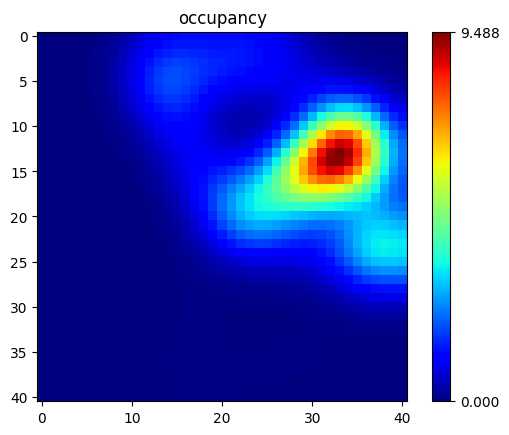

(0.0, 160.0)

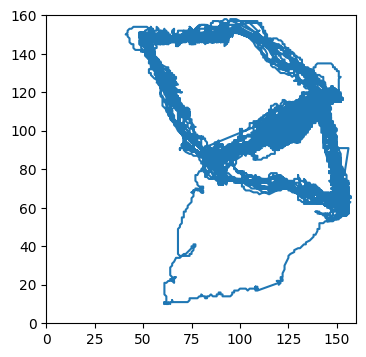

In [9]:
plot_map(placemap.occupancy, title= "occupancy")

plt.figure(figsize=(4,4))
plt.plot(position[:,0],position[:,1])
plt.xlim([0,160])
plt.ylim([0,160])

In [ ]:
# Window size and polynomial degree for the Savitzky-Golay filter
window_size = 10
poly_degree = 1

for window_size in [5, 10, 20, 25]:
    p=1
    for poly in range(1,5):
        smooth_speed = savgol_filter(speed, window_size, poly)

        plt.figure(figsize=(24,30), dpi = 500)
        plt.subplot(5,1,p)
        plt.plot(smooth_speed)
        plt.title("window "+ str(window_size)+" poly_degree: "+str(poly))
        p+=1
    plt.subplot(5,1,p)
    plt.plot(speed)
#     plt.ylim([0, 1200])
    plt.show()

In [ ]:
for i in range(1,2):    
    binned_data[i, :][low_speed_index] = 0 ## dont want to include spikes that happened when the animal was not moving
    
    bin_sizes = [3.2, 4]
    smoothing = [ 2,2.5,3]
    #################################### occupancy sd is 2.5
    for bin_size in bin_sizes:
        for sd in smoothing:
    
            placemap = FiringRateMap(
                                                    binned_data[i, :],
                                                    speed_filtered_positions, 
                                                    np.array([160,160]), 
                                                    np.array([bin_size,bin_size]), 
                                                    20,
                                                    smooth_sd = sd
            )
            jcl.visualization.plot_map(placemap, title = str(bin_size) +" bin size      smoothing: "+str(sd))
        jcl.visualization.plot_map(placemap.occupancy)


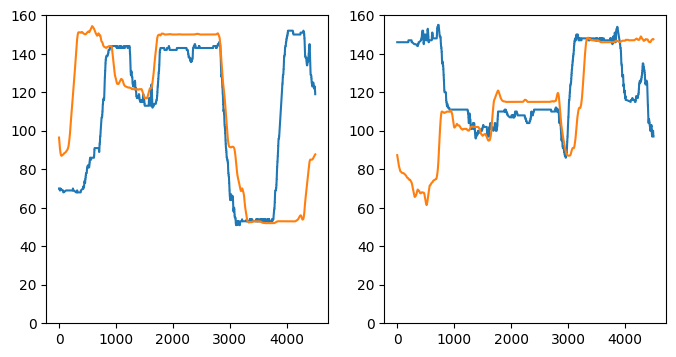

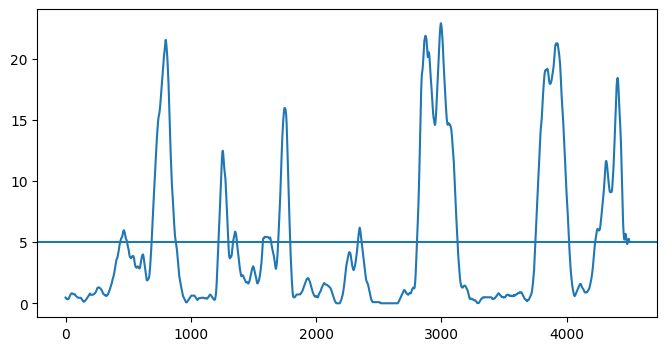

In [8]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(position[11500:16000,0])
plt.plot(smooth_pos[11500:16000,0])
plt.ylim([0,160])
plt.yticks([0,20,40,60,80,100,120,140,160])
plt.subplot(1,2,2)
plt.plot(position[11500:16000,1])
plt.plot(smooth_pos[11500:16000,1])
plt.ylim([0,160])
plt.yticks([0,20,40,60,80,100,120,140,160])

plt.figure(figsize=(8,4))
plt.plot(smooth_speed[11500:16000])
plt.axhline(y=5)


In [ ]:
(np.where( (speed_filtered_positions[11500:16000,0] == 0) & (speed_filtered_positions[11500:16000,1] == 0))[0].size)/(16000-11500)

In [ ]:
(np.where( (position[11500:16000,0] == 0) & (position[11500:16000,1] == 0))[0].size)

In [ ]:
def calc_speed(positions, bin_len):
    """ Calculate animal speed. Units of positions / s.

        Args:
            positions - array of positions of shape (n,1) or (n,2)
            bin_len - duration of temporal bins in ms
        Return:
            speed - animal speed in each recorded point, same shape as positions
    """
    speed = []
    for i in range(1, len(positions)):
        prev_p = positions[i-1]
        current_p = positions[i]
        dist = np.linalg.norm(current_p-prev_p)
        speed.append(dist*1000 / bin_len )
    return [speed[0]] + speed

from scipy.signal import savgol_filter


speed= calc_speed(position, 20)
speed=np.array(speed)
speed_violation_index = np.where(speed>90)[0]
for i in speed_violation_index:
#     print(speed[i])
    speed[i]= np.mean(speed[i-10:i])
#     print(speed[i])
# Window size and polynomial degree for the Savitzky-Golay filter

window_size = 10
poly_degree = 2

# Apply the Savitzky-Golay filter
smooth_speed = savgol_filter(speed, window_size, poly_degree)

plt.figure(figsize=(24,12), dpi = 500)
plt.subplot(2,1,1)
plt.plot(smooth_speed)
plt.subplot(2,1,2)
plt.plot(speed)
# plt.ylim([0, 1200])
plt.show()

In [ ]:
def speed_filter(positions, bin_len, speed_thr, speed_violation = 90):
    """ Filter positions based on speed.
        Return both parts where speed > speed_thr and where speed <= speed_thr.

            positions - array of positions of shape (n,1) or (n,2)
            bin_len - duration of temporal bins in ms
            speed_thr - threshold for speed
            speed_violation - speed in cm/s that is max achievable by rat
        Return:
            positions speed filtered with low speed set to 0, low speed position indices
    """
    assert speed_thr is not None
    speed = np.array(jcl.utils.calc_speed(positions, bin_len))
    
    speed_violation_index = np.where(speed > speed_violation)[0]
    for i in speed_violation_index:
        speed[i]= np.mean(speed[i-10:i])
        
    # Window size and polynomial degree for the Savitzky-Golay filter
    window_size = 10
    poly_degree = 2
    # Apply the Savitzky-Golay filter
    smooth_speed = savgol_filter(speed, window_size, poly_degree)
    
    speed_l_idx = smooth_speed < speed_thr
    
    speed_filtered_positions = positions.copy()
    speed_filtered_positions[speed_l_idx] = [0,0]
    return speed_filtered_positions, speed_l_idx

speed_filtered_positions, low_speed_index = speed_filter(position, 20, 5)